In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import bq_helper
from google.cloud import bigquery

import folium
from folium.plugins import HeatMap, HeatMapWithTime

In [2]:
# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "openaq" dataset
dataset_ref = client.dataset("openaq", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# List all the tables in the "openaq" dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset (there's only one!)
for table in tables:  
    print(table.table_id)

Using Kaggle's public dataset BigQuery integration.
global_air_quality


In [3]:
# Construct a reference to the "global_air_quality" table
table_ref = dataset_ref.table("global_air_quality")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "global_air_quality" table
client.list_rows(table, max_results=5).to_dataframe()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
0,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,co,910.00,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
1,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,no2,131.87,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
2,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,o3,15.57,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
3,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,pm25,45.62,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
4,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,so2,4.49,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25


In [4]:
# Query to select all the items from the "city" column where the "country" column is 'US'
query = """
        SELECT *
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE country = 'IN'
        """

In [5]:
# Create a "Client" object
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [6]:
# Set up the query
query_job = client.query(query)

In [7]:
# API request - run the query, and return a pandas DataFrame
df_in = query_job.to_dataframe()

In [8]:
df_in.shape

(1531, 11)

In [9]:
df_in.head()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
0,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,co,910.00,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
1,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,no2,131.87,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
2,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,o3,15.57,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
3,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,pm25,45.62,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
4,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,so2,4.49,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25


In [10]:
print(f"Mean value of different pollutants in india")

for p in df_in.pollutant.unique():
    mean_v = df_in[(df_in.pollutant==p)].value.mean()
    print(f"{p} : {mean_v} µg/m³")

Mean value of different pollutants in india
co : 1343.190827067669 µg/m³
no2 : 28.566250000000025 µg/m³
o3 : 26.335569105691054 µg/m³
pm25 : 60.80805970149254 µg/m³
so2 : 51.285529411764784 µg/m³
pm10 : 109.93866379310344 µg/m³


In [12]:
def avg_pollutant_by_city(c):
    x = []
    for p in df_in.pollutant.unique():
        mean_v = df_in[(df_in.city==c) & (df_in.pollutant==p)].value.mean()
        mwan_v = round(mean_v, 2)
        x.append(mean_v)
    return x


try:
    os.remove("openaq_city_india.csv")
except OSError:
    pass

with open("openaq_city_india.csv", 'a+') as f:
    print("City,Avg_co,Avg_no2,Avg_o3,Avg_pm25,Avg_so2,Avg_pm10", file=f)
    for c in df_in.city.unique():
        print(c,',',end='', file=f)
        print(*avg_pollutant_by_city(c), sep=',', file=f)

In [18]:
df_cities_in = pd.read_csv("openaq_city_india.csv")
df_cities_in.head()

,City,Avg_co,Avg_no2,Avg_o3,Avg_pm25,Avg_so2,Avg_pm10
0,Bengaluru,719.0,145.046000,10.300,26.953333,5.4900,83.2100
1,Chennai,2730.0,11.860000,13.305,75.266667,13.1200,NaN
2,Hyderabad,185.0,28.333333,13.000,21.500000,6.3500,55.5000
3,Pune,1030.0,3.420000,12.020,37.500000,16.1950,89.7000
4,Mumbai,780.0,3.547500,12.940,26.840000,7.5475,83.9925


In [19]:
df_cities_in.shape

(170, 7)

In [20]:
df_cities_in.tail()

,City,Avg_co,Avg_no2,Avg_o3,Avg_pm25,Avg_so2,Avg_pm10
165,Kochi,1370.000000,33.550000,1.00,23.000000,16.510000,31.000000
166,Ernakulam,2460.000000,0.000000,NaN,12.000000,2.770000,42.000000
167,India,NaN,NaN,NaN,17.600000,NaN,NaN
168,Satna,80000.000000,NaN,NaN,11.000000,7.000000,265.000000
169,Delhi,2533.847209,48.203333,32.04,131.309318,19.852353,159.827949


In [21]:
df_cities_in.drop(167, inplace=True)

In [22]:
df_cities_in.reset_index(drop=True, inplace=True)

In [23]:
df_cities_in.shape

(169, 7)

In [24]:
df_cities_in.columns

Index(['City', 'Avg_co', 'Avg_no2', 'Avg_o3', 'Avg_pm25', 'Avg_so2',
       'Avg_pm10'],
      dtype='object')

In [25]:
print("Worst indian cities in different pollutants")
for c in ['Avg_co', 'Avg_no2', 'Avg_o3', 'Avg_pm25', 'Avg_so2', 'Avg_pm10']:
    print(c,': ',sep='',end='')
    print(*df_cities_in.sort_values(by=[c],ascending=False)['City'].values[:5],sep=',')

Worst indian cities in different pollutants
Avg_co: Satna ,Nandesari ,Bagalkot ,Loni Dehat ,BDPO Office 
Avg_no2: Varanasi ,Bengaluru ,GVMC Building ,Kanpur ,Coimbatore 
Avg_o3: MKN Rd ,Gate No.3 ,Howrah ,Government District Hospital ,Ordali Bazar 
Avg_pm25: K J Somaiya Hospital ,Hajipur ,Varanasi ,Gurgaon ,Mahanadi Coal fields  Limited 
Avg_so2: Kalyan ,Top Floor ,Circuit House ,Mini Secretariat ,Nandesari 
Avg_pm10: CAAQMS-Maharashtra Pollution Control Board ,Near Main Gate Number 7 ,Varanasi ,Jaipur ,Mahanadi Coal fields  Limited 


In [26]:
openaq = bq_helper.BigQueryHelper(active_project='bigquery-public-data',
                                 dataset_name='openaq')

query = """ 
select pollutant, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000  and country  = 'IN' and extract(year from timestamp) < 2018
group by pollutant"""

it_pop_18 = openaq.query_to_pandas(query)
print('Pollutant till 2018')
print(it_pop_18)

print('\n')

query = """ 
select pollutant, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000  and country  = 'IN' and extract(year from timestamp) < 2019
group by pollutant"""

it_pop_19 = openaq.query_to_pandas(query)
print('Pollutant till 2019')
print(it_pop_19)

print('\n')

query = """ 
select pollutant, round(avg(value)) as avg_value
from `bigquery-public-data.openaq.global_air_quality`
where unit = 'µg/m³' and value > 0 and value <10000  and country  = 'IN' and extract(year from timestamp) = 2020
group by pollutant"""

it_pop_20 = openaq.query_to_pandas(query)
print('Pollutant in 2020')
print(it_pop_20)

Using Kaggle's public dataset BigQuery integration.
Pollutant till 2018
  pollutant  avg_value
0        o3       50.0
1        co     1283.0
2      pm25       67.0
3       so2       28.0
4       no2       69.0
5      pm10      213.0


Pollutant till 2019
  pollutant  avg_value
0        co     1175.0
1       no2       65.0
2        o3       38.0
3      pm25      117.0
4       so2       16.0
5      pm10      235.0


Pollutant in 2020
  pollutant  avg_value
0        co      781.0
1       no2       25.0
2        o3       26.0
3      pm10      104.0
4      pm25       56.0
5       so2       61.0


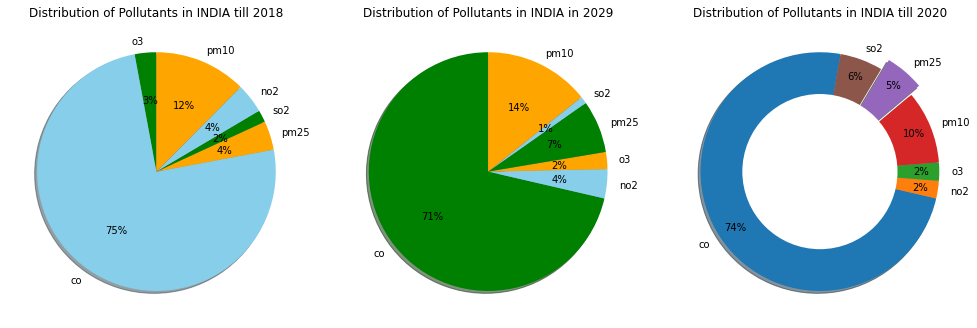

In [27]:
f, ax = plt.subplots(1,3, figsize = (14,5))
ax1, ax2, ax3 = ax.flatten()

ax1.set_title('Distribution of Pollutants in INDIA till 2018')
ax1.pie(x = it_pop_18['avg_value'], labels = it_pop_18['pollutant'], shadow = True,
       autopct ='%1.0f%%', startangle = 90, colors = ['green','skyblue','orange'] )

ax2.set_title('Distribution of Pollutants in INDIA in 2029')
ax2.pie(x = it_pop_19['avg_value'], labels = it_pop_19['pollutant'], shadow = True,
       autopct ='%1.0f%%', startangle = 90, colors = ['green','skyblue','orange'] )

ax3.set_title('Distribution of Pollutants in INDIA till 2020')
ax3.pie(x = it_pop_20['avg_value'], labels = it_pop_20['pollutant'], shadow = True,
       autopct ='%1.0f%%', startangle = 80, pctdistance = 0.85, explode = (0,0,0,0,0.1,0))

centre_circle = plt.Circle((0,0),0.65,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
plt.show()

In [ ]:
f=folium.Figure(width=1500,height=800)
m = folium.Map(location=[21.1458,79.0882], tiles='openstreetmap', zoom_start=5)

pollutants={'co':'Carbon Monoxide', 'no2':'Nitrogen Dioxide','so2':'Sulphar Dioxide','pm10':'Particulate Matter 10', 'pm25':'Particulate Matter 2.5'}
for p in pollutants.keys():
    filtered_df=df_in[df_in['pollutant']==p]
    fg=folium.FeatureGroup(name=pollutants[p])
    HeatMap(data=filtered_df[['latitude','longitude']],radius=12).add_to(fg)
    fg.add_to(m)

#displaing map
folium.LayerControl().add_to(m)
f.add_child(m)
f